In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from cmdstanpy import CmdStanModel

In [54]:
F = len("Dominik")
L = len("Zurek")
N = (L+F)*100

### Generate data

In [55]:
%%writefile code_1.stan

data {
    int<lower=1> N;
}

generated quantities {
    real theta = 0.01;
    array [N] real y;
    for (i in 1:N) {
        if (bernoulli_rng(theta)) {
            y[i] = normal_rng(10,10);
        }
        else {
            y[i] = normal_rng(0, 1);
        }
    }
}

Overwriting code_1.stan


In [56]:
%%writefile code_2.stan

data {
    int<lower=1> N;
}

generated quantities {
    matrix[N,3] X;
    
    {vector [N] zeros = rep_vector(0,N);
     
     for (j in 1:3) {
         X[:,j]=to_vector(normal_rng(zeros,1));
     }
    }
    
    vector [3] beta;
    beta = [2, 1, 0.5]';
    
    array [N] real y;
    y = normal_rng(X*beta,1);
}

Overwriting code_2.stan


In [57]:
sim1 = CmdStanModel(stan_file="code_1.stan")

INFO:cmdstanpy:compiling stan file /home/code_1.stan to exe file /home/code_1
INFO:cmdstanpy:compiling stan file /home/code_1.stan to exe file /home/code_1
INFO:cmdstanpy:compiled model executable: /home/code_1


In [58]:
data1=sim1.sample(data={'N': N}, seed=25042023, iter_sampling=1, iter_warmup=0, chains=1)

INFO:cmdstanpy:CmdStan start processing
chain 1 |████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [59]:
df1 = data1.draws_pd()

In [60]:
df1.head()

,lp__,accept_stat__,theta,y[1],y[2],y[3],y[4],y[5],y[6],y[7],...,y[1191],y[1192],y[1193],y[1194],y[1195],y[1196],y[1197],y[1198],y[1199],y[1200]
0,0.0,0.0,0.01,1.16549,0.079893,1.2503,0.824636,-2.04719,-0.325304,0.958276,...,-0.28231,0.485446,0.437636,1.90433,1.22931,-0.699222,1.11275,0.123205,1.9906,0.992505


In [ ]:
sim2 = CmdStanModel(stan_file="code_2.stan")

In [61]:
data2=sim2.sample(data={'N': N}, seed=25042023, iter_sampling=1, iter_warmup=0, chains=1)

INFO:cmdstanpy:CmdStan start processing
chain 1 |████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [62]:
df2 = data2.draws_pd()

In [63]:
df2.head()

,lp__,accept_stat__,"X[1,1]","X[2,1]","X[3,1]","X[4,1]","X[5,1]","X[6,1]","X[7,1]","X[8,1]",...,y[1191],y[1192],y[1193],y[1194],y[1195],y[1196],y[1197],y[1198],y[1199],y[1200]
0,0.0,0.0,1.16549,-0.27026,-1.73173,-1.22371,-0.314025,0.485908,-0.325304,-0.979494,...,1.4748,-3.33804,0.240961,3.16959,1.86098,0.533307,1.77148,3.14666,2.93302,-0.536841


### Fit to the data

In [64]:
%%writefile code_3.stan

data {
    int N;
    array [N] real y;
}

parameters {
    real<lower=0> sigma;
    real mu;
}

model {
    target+=-2*log(sigma);
    target+=normal_lpdf(y|mu,sigma);
}

generated quantities {
    vector[N] log_lik;
    array [N] real y_hat;
    for (j in 1:N) {
        log_lik[j] = normal_lpdf(y[j]|mu,sigma);
        y_hat[j] = normal_rng(mu,sigma);
    }
}

Overwriting code_3.stan


In [65]:
%%writefile code_4.stan

data {
    int N;
    array [N] real y;
}

parameters {
    real<lower=0> sigma;
    real mu;
    real<lower=0> nu;
}

model {
    target+=-2*log(sigma);
    target+=gamma_lpdf(nu|2,0.1);
    target+=student_t_lpdf(y|nu,mu,sigma);
}

generated quantities {
    vector[N] log_lik;
    array [N] real y_hat;
    for (j in 1:N) {
        log_lik[j] = student_t_lpdf(y[j]|nu,mu,sigma);
        y_hat[j] = student_t_rng(nu,mu,sigma);
    }
}

Overwriting code_4.stan


In [66]:
sim3 = CmdStanModel(stan_file="code_3.stan")

INFO:cmdstanpy:compiling stan file /home/code_3.stan to exe file /home/code_3
INFO:cmdstanpy:compiled model executable: /home/code_3


In [67]:
sim4 = CmdStanModel(stan_file="code_4.stan")

INFO:cmdstanpy:compiling stan file /home/code_4.stan to exe file /home/code_4
INFO:cmdstanpy:compiled model executable: /home/code_4


In [68]:
data_fit = {"N": N, "y": df1.loc[:, 'y[1]':f'y[{N}]'].values.reshape((N,))}
fit1 = sim3.sample(data=data_fit, seed=25042023)

INFO:cmdstanpy:CmdStan start processing
chain 1 |                                                                                                                                                                    | 00:00 Status
chain 2 |                                                                                                                                                                    | 00:00 Status

chain 3 |                                                                                                                                                                    | 00:00 Status


chain 1 |███████▍                                                                                                                                                            | 00:00 Status
chain 2 |███████▍                                                                                                                                                            | 00:00 Status


chain 4 |██████

chain 2 |████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 00:09 Sampling completed
chain 3 |████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 00:09 Sampling completed
chain 4 |████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 00:09 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [69]:
fit1.draws_pd().head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,sigma,mu,log_lik[1],...,y_hat[1191],y_hat[1192],y_hat[1193],y_hat[1194],y_hat[1195],y_hat[1196],y_hat[1197],y_hat[1198],y_hat[1199],y_hat[1200]
0,-2197.53,0.974521,0.868147,2.0,3.0,0.0,2198.76,1.51980,0.067841,-1.59833,...,-0.018170,3.457100,3.32102,1.476740,0.343193,0.316656,0.274066,-1.020930,-1.098320,3.762220
1,-2197.58,0.981809,0.868147,2.0,3.0,0.0,2197.84,1.50671,0.009833,-1.62302,...,-1.444000,0.721764,-1.97483,-0.767673,-0.536276,-0.487654,-0.146726,1.399330,-0.395931,-1.171850
2,-2197.69,0.989350,0.868147,2.0,3.0,0.0,2197.90,1.48668,0.020995,-1.61180,...,1.674440,-0.233602,1.37171,-0.004766,-4.565790,-1.727900,1.918300,-0.597542,2.556770,-1.642960
3,-2197.61,1.000000,0.868147,2.0,3.0,0.0,2197.73,1.48672,0.028574,-1.60790,...,1.703610,0.951459,1.39921,-0.652236,0.864515,1.831350,0.145742,0.220165,-0.726165,-1.127030
4,-2198.06,0.949796,0.868147,2.0,7.0,0.0,2198.23,1.54437,0.019751,-1.62875,...,0.282671,2.063210,1.11454,0.126137,2.061990,-0.815261,2.992730,1.719550,-0.763417,0.195065


In [70]:
fit2 = sim4.sample(data=data_fit, seed=25042023)

INFO:cmdstanpy:CmdStan start processing
chain 1 |                                                                                                                                                                    | 00:00 Status
chain 2 |                                                                                                                                                                    | 00:00 Status

chain 3 |                                                                                                                                                                    | 00:00 Status


chain 1 |███████▍                                                                                                                                                            | 00:00 Status
chain 2 |███████▍                                                                                                                                                            | 00:00 Status

chain 3 |███████

chain 1 |████████████████████████████████████████████████████████████████████████████▏                                                    | 00:07 Iteration: 1001 / 2000 [ 50%]  (Sampling)
chain 2 |██████████████████████████████████████████████████████████████████████████████████                                               | 00:08 Iteration: 1100 / 2000 [ 55%]  (Sampling)

chain 1 |██████████████████████████████████████████████████████████████████████████████████                                               | 00:09 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 4 |██████████████████████████████████████████████████████████████████████████████████                                               | 00:09 Iteration: 1100 / 2000 [ 55%]  (Sampling)
chain 1 |███████████████████████████████████████████████████████████████████████████████████████▉                                         | 00:11 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain 3 |███████████████████████████████████████████████


INFO:cmdstanpy:CmdStan done processing.


In [71]:
fit2.draws_pd().head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,sigma,mu,nu,...,y_hat[1191],y_hat[1192],y_hat[1193],y_hat[1194],y_hat[1195],y_hat[1196],y_hat[1197],y_hat[1198],y_hat[1199],y_hat[1200]
0,-1829.74,0.958022,0.761139,3.0,7.0,0.0,1829.96,0.896041,0.006020,5.46149,...,1.344300,0.447740,-0.186573,1.661340,-0.943658,0.471932,-1.020660,-1.201860,1.317440,0.293615
1,-1831.80,0.737406,0.761139,2.0,7.0,0.0,1832.99,0.873472,-0.032101,5.73372,...,-1.688790,-1.116030,0.596281,-0.840502,-0.797207,-0.160793,0.048363,0.577003,-0.719129,-0.577418
2,-1829.77,1.000000,0.761139,2.0,3.0,0.0,1831.57,0.896878,-0.013943,5.61262,...,0.164539,3.379190,-0.446368,1.104610,0.029110,0.731304,3.300880,2.139380,-0.197648,-0.184724
3,-1829.67,0.903954,0.761139,2.0,3.0,0.0,1830.68,0.926313,-0.007261,5.10749,...,0.240300,0.460573,0.403825,-0.566981,1.928340,0.722116,-1.326970,2.044780,0.863089,1.253620
4,-1831.59,0.902559,0.761139,2.0,7.0,0.0,1832.29,0.850962,-0.039736,4.52347,...,0.728126,1.709590,-1.030080,-1.397620,0.282291,0.100683,1.106820,2.190760,-0.757257,-0.592234


### Model comparison

In [72]:
idata1 = az.from_cmdstanpy(posterior=fit1)
idata2 = az.from_cmdstanpy(posterior=fit2)

In [73]:
idata1

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

In [74]:
idata2

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

#### PSIS-LOOCV

In [75]:
model_dict = {"Normal model": idata1, "Student model": idata2}
model_comparison = az.compare(model_dict, ic="loo", scale="deviance")
print(model_comparison)

/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


               rank          loo      p_loo       d_loo        weight  \
Student model     0  3663.335124   5.269548    0.000000  1.000000e+00   
Normal model      1  4436.027903  43.232847  772.692779  7.966605e-10   

                       se         dse  warning loo_scale  
Student model   74.494834    0.000000    False  deviance  
Normal model   341.366856  290.471743     True  deviance  


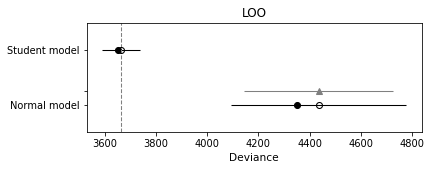

In [76]:
az.plot_compare(model_comparison)
plt.title('LOO')
plt.show()

#### WAIC

In [77]:
model_comparison = az.compare(model_dict, ic="waic", scale="deviance")
print(model_comparison)

/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


               rank         waic     p_waic      d_waic        weight  \
Student model     0  3663.188760   5.196367    0.000000  1.000000e+00   
Normal model      1  4439.426439  44.932115  776.237679  2.286242e-10   

                       se         dse  warning waic_scale  
Student model   74.441688    0.000000     True   deviance  
Normal model   344.291243  293.626811     True   deviance  


/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


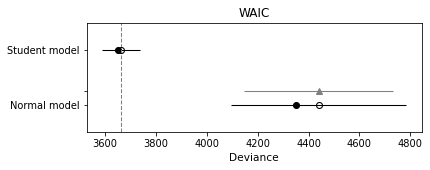

In [78]:
az.plot_compare(model_comparison)
plt.title('WAIC')
plt.show()

Lower WAIC and PSIS-LOOCV metrics indicate better model performance. Student model is better than Normal model in those areas, but we might also want to take into account simplicity and interpretability of a model, when drawing conclusions. The p_loo and p_waic stats are estimates of the effective number of parameters in a model. Student model performs ~30% better than Normal model and is also ~9 times less complex.

### Compare models with different number of predictors

In [79]:
%%writefile code_5.stan

data {
    int N;
    int K;
    array [N] real y;
    matrix[N,K] X;
}

parameters {
    real<lower=0> sigma;
    vector[K] beta;
}

transformed parameters {
    vector [N] mu;
    mu = X*beta;
}

model {
    y ~ normal(mu, sigma);
}

generated quantities {
    vector[N] log_lik;
    array [N] real y_hat;
    for (j in 1:N) {
        log_lik[j] = normal_lpdf(y[j]|mu[j], sigma);
        y_hat[j] = normal_rng(mu[j],sigma);
    }
}

Overwriting code_5.stan


In [80]:
sim5 = CmdStanModel(stan_file="code_5.stan")

INFO:cmdstanpy:compiling stan file /home/code_5.stan to exe file /home/code_5
INFO:cmdstanpy:compiled model executable: /home/code_5


In [81]:
data_fit = {'N': N, 'K': 1, 'y': df2.loc[:, 'y[1]':f'y[{N}]'].values.reshape((N,)), 'X': df2.loc[:, 'X[1,1]':f'X[{N},1]'].values.reshape((N,1))}
pred1 = sim5.sample(data=data_fit, seed=25042023)

INFO:cmdstanpy:CmdStan start processing
chain 1 |                                                                                                                                                                    | 00:00 Status
chain 2 |                                                                                                                                                                    | 00:00 Status

chain 3 |                                                                                                                                                                    | 00:00 Status


chain 1 |███████▍                                                                                                                                                            | 00:00 Status
chain 2 |███████▍                                                                                                                                                            | 00:00 Status


chain 4 |██████

chain 3 |███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 00:09 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 00:11 Iteration: 1700 / 2000 [ 85%]  (Sampling)
chain 2 |█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 00:11 Iteration: 1700 / 2000 [ 85%]  (Sampling)

chain 3 |█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 00:11 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 00:12 Iteration: 1800 / 2000 [ 90%]  (Sampling)
chain 2 |██████████████████████████████████████████████


INFO:cmdstanpy:CmdStan done processing.


In [82]:
data_fit = {'N': N, 'K': 2, 'y': df2.loc[:, 'y[1]':f'y[{N}]'].values.reshape((N,)), 'X': df2.loc[:, 'X[1,1]':f'X[{N},2]'].values.reshape((N,2))}
pred2 = sim5.sample(data=data_fit, seed=25042023)

INFO:cmdstanpy:CmdStan start processing
chain 1 |                                                                                                                                                                    | 00:00 Status
chain 2 |                                                                                                                                                                    | 00:00 Status

chain 3 |                                                                                                                                                                    | 00:00 Status


chain 1 |███████▍                                                                                                                                                            | 00:00 Status

chain 3 |███████▍                                                                                                                                                            | 00:00 Status
chain 2 |███████

chain 3 |███████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 00:07 Iteration: 1400 / 2000 [ 70%]  (Sampling)
chain 2 |███████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 00:08 Iteration: 1400 / 2000 [ 70%]  (Sampling)


chain 1 |█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 00:09 Iteration: 1500 / 2000 [ 75%]  (Sampling)

chain 3 |█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 00:09 Iteration: 1500 / 2000 [ 75%]  (Sampling)
chain 2 |█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 00:09 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████████████████████████████████████████


INFO:cmdstanpy:CmdStan done processing.


In [83]:
data_fit = {'N': N, 'K': 3, 'y': df2.loc[:, 'y[1]':f'y[{N}]'].values.reshape((N,)), 'X': df2.loc[:, 'X[1,1]':f'X[{N},3]'].values.reshape((N,3))}
pred3 = sim5.sample(data=data_fit, seed=25042023)

INFO:cmdstanpy:CmdStan start processing
chain 1 |                                                                                                                                                                    | 00:00 Status
chain 2 |                                                                                                                                                                    | 00:00 Status

chain 3 |                                                                                                                                                                    | 00:00 Status


chain 1 |███████▍                                                                                                                                                            | 00:00 Status
chain 2 |███████▍                                                                                                                                                            | 00:00 Status

chain 3 |███████

chain 2 |██████████████████████████████████████████████████████████████████████████████████                                               | 00:04 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████████████████████████████████████████████████████████████████████████████████                                               | 00:04 Iteration: 1100 / 2000 [ 55%]  (Sampling)

chain 3 |██████████████████████████████████████████████████████████████████████████████████                                               | 00:04 Iteration: 1100 / 2000 [ 55%]  (Sampling)
chain 2 |███████████████████████████████████████████████████████████████████████████████████████▉                                         | 00:06 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████████████████████████████████████████████████████████████████████████████████████▉                                         | 00:06 Iteration: 1200 / 2000 [ 60%]  (Sampling)

chain 3 |█████████████████████████████████████████████


INFO:cmdstanpy:CmdStan done processing.


In [84]:
idata1 = az.from_cmdstanpy(posterior=pred1)
idata2 = az.from_cmdstanpy(posterior=pred2)
idata3 = az.from_cmdstanpy(posterior=pred3)

In [85]:
model_dict = {"Model with 1 predictor": idata1, "Model with 2 predictors": idata2, "Model with 3 predictors": idata3}

In [86]:
model_comparison = az.compare(model_dict, ic="loo", scale="deviance")
print(model_comparison)

                         rank          loo     p_loo        d_loo  \
Model with 1 predictor      0  4324.954811  1.968842     0.000000   
Model with 3 predictors     1  5619.718538  4.029207  1294.763727   
Model with 2 predictors     2  5626.813903  3.045952  1301.859092   

                               weight         se        dse  warning loo_scale  
Model with 1 predictor   1.000000e+00  47.939234   0.000000    False  deviance  
Model with 3 predictors  0.000000e+00  49.825134  55.218831    False  deviance  
Model with 2 predictors  7.019940e-13  49.713365  55.184157    False  deviance  


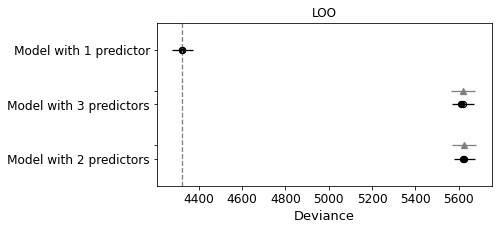

In [87]:
az.plot_compare(model_comparison)
plt.title('LOO')
plt.show()

In [88]:
model_comparison = az.compare(model_dict, ic="waic", scale="deviance")
print(model_comparison)

                         rank         waic    p_waic       d_waic  \
Model with 1 predictor      0  4324.954964  1.968918     0.000000   
Model with 3 predictors     1  5619.718817  4.029347  1294.763853   
Model with 2 predictors     2  5626.813838  3.045920  1301.858874   

                               weight         se        dse  warning  \
Model with 1 predictor   1.000000e+00  47.939259   0.000000    False   
Model with 3 predictors  3.082444e-12  49.825201  55.218873    False   
Model with 2 predictors  0.000000e+00  49.713384  55.184157    False   

                        waic_scale  
Model with 1 predictor    deviance  
Model with 3 predictors   deviance  
Model with 2 predictors   deviance  


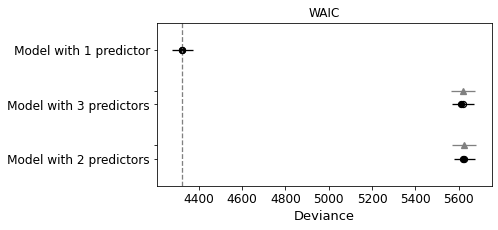

In [89]:
az.plot_compare(model_comparison)
plt.title('WAIC')
plt.show()

Same as in the previous exercise the simplest model (with 1 predictor) appears to be the best out of the 3.